# This is homework of third week.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's start with loading the dataframe

In [2]:
df = pd.read_csv('housing.csv')

Explore data

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

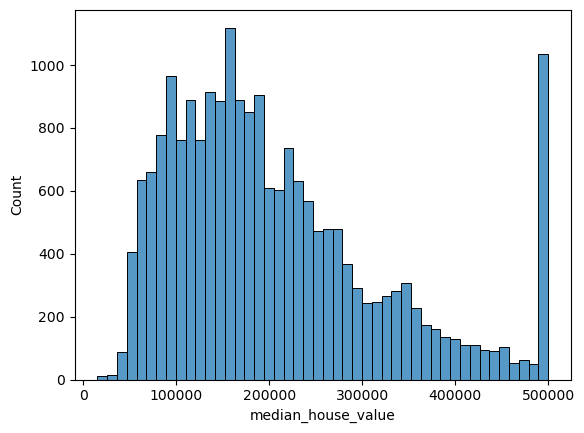

In [4]:
sns.histplot(df.median_house_value)

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

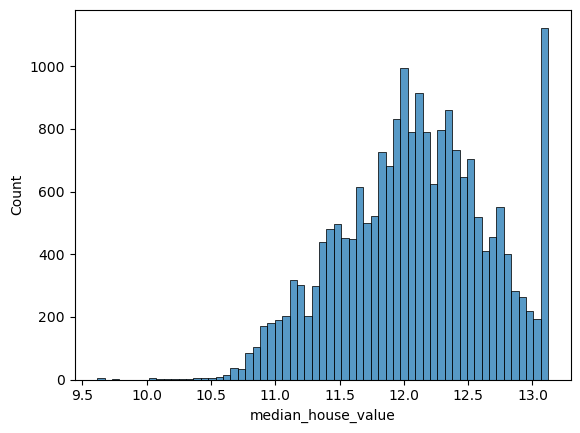

In [5]:
sns.histplot(np.log1p(df.median_house_value))

No tail in distribution. Now let's select features required for homework and prepare data

In [6]:
cols = ['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value','ocean_proximity']

In [7]:
df = df[cols]

In [8]:
df = df.fillna(0.0)

In [9]:
df['rooms_per_household'] = df['total_rooms']/df['households']
df['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']
df['population_per_household'] = df['population']/df['households']

In [10]:
cols.append(['rooms_per_household','bedrooms_per_room','population_per_household'])

In [11]:
numerical_cols = df.dtypes[df.dtypes == np.float64].index

Question 1

* What is the most frequent observation (mode) for the column ocean_proximity?

In [12]:
df.ocean_proximity.mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

Question 2

* Create the correlation matrix for the numerical features of your train dataset.
* In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
* What are the two features that have the biggest correlation in this dataset?

In [13]:
correlation_matrix = np.zeros((len(numerical_cols),len(numerical_cols)))
for row, col_row in enumerate(numerical_cols):
    for col, col_col in enumerate(numerical_cols):
        if col_row==col_col:
            correlation_matrix[row,col] = 0.0
        else:    
            correlation_matrix[row,col] = np.corrcoef(df[col_row],df[col_col])[0,1]
        #print(col_row,col_col,correlation_matrix[row,col])
print(correlation_matrix.max())
print(abs(correlation_matrix.max()))
indices = np.where(correlation_matrix == correlation_matrix.max())

0.9665072400420386
0.9665072400420386


In [14]:
print(correlation_matrix[indices[0][0],indices[0][1]])
print(indices[0])
print(numerical_cols[indices[0][0]],numerical_cols[indices[0][1]])

0.9665072400420386
[4 6]
total_bedrooms households


In [15]:
#for col in numerical_cols:
#    print(col)
#    print(df[numerical_cols].corrwith(df[col]))

Setting new binary variable

In [16]:
average = df.median_house_value.mean()
df['above_average'] = np.where(df['median_house_value']>average,1,0)

Splitting data

In [17]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.2/(0.2+0.6), random_state=42)
print(len(df_train), len(df_val), len(df_test))
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train_cat = df_train.above_average.values
y_val_cat = df_val.above_average.values
y_test_cat = df_test.above_average.values
y_train_num = df_train.median_house_value.values
y_val_num = df_val.median_house_value.values
y_test_num = df_test.median_house_value.values
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

12384 4128 4128


Question 3

* Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
* What is the value of mutual information?
* Round it to 2 decimal digits using round(score, 2)

In [18]:
#lets set cols that will be used further
numerical = list(numerical_cols[numerical_cols!='median_house_value'])
categorical = ['ocean_proximity']

In [19]:
from sklearn.metrics import mutual_info_score
#def mutual_info_above_average_score(series):
#    return mutual_info_score(series, df_train.above_average)
#mi = df_train[categorical].apply(mutual_info_above_average_score)
#mi.sort_values(ascending=False)
mutual_info_score(df_train['ocean_proximity'],y_train_cat)

0.10138385763624205

Question 4

* Now let's train a logistic regression
* Remember that we have one categorical variable ocean_proximity in the data. Include it using one-hot encoding.
* Fit the model on the training dataset.
 -- To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
 -- model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [20]:
#One Hot Encoding
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
train_dict = df_train[numerical+categorical].to_dict(orient='records')
dv.fit_transform(train_dict)
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [21]:
df_train[numerical+categorical].iloc[0,:]

latitude                        34.43
longitude                     -119.67
housing_median_age               39.0
total_rooms                    1467.0
total_bedrooms                  381.0
population                     1404.0
households                      374.0
median_income                  2.3681
rooms_per_household           3.92246
bedrooms_per_room            0.259714
population_per_household     3.754011
ocean_proximity             <1H OCEAN
Name: 0, dtype: object

In [22]:
X_train[0,:]

array([ 2.59713701e-01,  3.74000000e+02,  3.90000000e+01,  3.44300000e+01,
       -1.19670000e+02,  2.36810000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.40400000e+03,
        3.75401070e+00,  3.92245989e+00,  3.81000000e+02,  1.46700000e+03])

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train_cat)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [24]:
y_pred_val_cat = model.predict(X_val)

In [25]:
y_pred_val_cat

array([0, 0, 1, ..., 1, 1, 0])

In [26]:
y_pred_val_prob_cat = model.predict_proba(X_val)

In [27]:
y_pred_val_prob_cat

array([[0.91991588, 0.08008412],
       [0.82569691, 0.17430309],
       [0.04759803, 0.95240197],
       ...,
       [0.03895262, 0.96104738],
       [0.14865781, 0.85134219],
       [0.52792983, 0.47207017]])

In [28]:
y_pred_val_prob_cat = model.predict_proba(X_val)[:, 1]

In [29]:
y_pred_val_prob_cat

array([0.08008412, 0.17430309, 0.95240197, ..., 0.96104738, 0.85134219,
       0.47207017])

In [32]:
accuracy_gen = model.score(X_val, y_val_cat)
print('Accuracy: '+str(round(accuracy_gen,2)))
print('Accuracy full: '+str(accuracy_gen))

Accuracy: 0.84
Accuracy full: 0.8359980620155039


Question 5

In [43]:
features_gen = numerical+categorical
differencies = []
differencies_abs = []
for feature in features_gen:
    print('Excluding '+feature)
    features = features_gen.copy()
    features.remove(feature)

    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train[features].to_dict(orient='records')
    dv.fit_transform(train_dict)
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    test_dict = df_test[features].to_dict(orient='records')
    X_test = dv.transform(test_dict)
    
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train_cat)
    accuracy = model.score(X_val, y_val_cat)
    difference = accuracy_gen - accuracy
    print('Accuracy: '+str(accuracy))
    print('Difference:'+str(difference)+'\n')
    differencies.append(difference)
    differencies_abs.append(abs(difference))

Excluding latitude
Accuracy: 0.8335755813953488
Difference:0.002422480620155043

Excluding longitude
Accuracy: 0.8369670542635659
Difference:-0.0009689922480620172

Excluding housing_median_age
Accuracy: 0.8306686046511628
Difference:0.005329457364341095

Excluding total_rooms
Accuracy: 0.8374515503875969
Difference:-0.0014534883720930258

Excluding total_bedrooms
Accuracy: 0.8362403100775194
Difference:-0.00024224806201555982

Excluding population
Accuracy: 0.8263081395348837
Difference:0.009689922480620172

Excluding households
Accuracy: 0.8333333333333334
Difference:0.002664728682170492

Excluding median_income
Accuracy: 0.7851259689922481
Difference:0.05087209302325579

Excluding rooms_per_household
Accuracy: 0.8355135658914729
Difference:0.0004844961240310086

Excluding bedrooms_per_room
Accuracy: 0.8362403100775194
Difference:-0.00024224806201555982

Excluding population_per_household
Accuracy: 0.8367248062015504
Difference:-0.0007267441860465684

Excluding ocean_proximity
Accura

In [39]:
min(differencies)

-0.0014534883720930258

In [44]:
min(differencies_abs)


0.00024224806201555982

Question 6

In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
features = features_gen.copy()
dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
dv.fit_transform(train_dict)
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[features].to_dict(orient='records')
X_test = dv.transform(test_dict)

alpha_list = [0, 0.01, 0.1, 1., 10.]

for alpha in alpha_list:
    print('Alpha:'+str(alpha))
    model = Ridge(alpha=alpha, solver="sag", random_state=42)
    model.fit(X_train, np.log1p(y_train_num))
    y_val_num_pred = model.predict(X_val)
    print('RMSE_val_log:'+str(mean_squared_error(np.log1p(y_val_num),y_val_num_pred)**0.5))
    #print('RMSE_val:'+str(mean_squared_error(np.expm1(y_val_num_pred),y_val_num)**0.5))

Alpha:0
RMSE_val_log:0.524063570701514
Alpha:0.01
RMSE_val_log:0.524063570718629
Alpha:0.1
RMSE_val_log:0.5240635708812071
Alpha:1.0
RMSE_val_log:0.5240635725155536
Alpha:10.0
RMSE_val_log:0.5240635888333284
